<a href="https://colab.research.google.com/github/eyaguirat10/CoWin-Breast-Cancer-Detection/blob/eya/Eya_Guirat_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Business Understanding

## **Problem Statement**

Breast cancer is one of the most common and life-threatening diseases affecting women worldwide. According to the World Health Organization, it accounts for a significant proportion of cancer-related deaths among women, with **approximately 2.3 million new cases diagnosed each year**. While the highest incidence is usually observed in women aged **40 to 70**, younger women are increasingly being diagnosed, highlighting the need for vigilance across all age groups. Men can also develop breast cancer, though it is much rarer.

Early detection of breast cancer is crucial because survival rates are significantly higher when the disease is identified at an initial stage. However, **late diagnosis remains common**, particularly in regions with limited access to screening programs, diagnostic facilities, or trained specialists. Factors contributing to delayed detection include:
- Socio-economic barriers  
- Lack of awareness about breast health  
- Cultural stigmas  
- Shortages of radiologists or screening centers  

In some areas, women may delay seeking care due to fear, misinformation, or limited healthcare infrastructure — leading to advanced diagnoses when treatment is more difficult and costly.

Breast cancer can manifest in different forms — **ductal carcinoma, lobular carcinoma, and other subtypes** — each with distinct characteristics and progression rates. The disease may present **asymptomatically** in its early stages, which is why imaging techniques such as **mammography** are critical for screening. Even with mammograms, subtle signs like **microcalcifications** or small lesions can be easily overlooked, even by experienced radiologists.

This issue is particularly pressing in regions where incidence is high and **medical resources are limited**, such as parts of **North Africa**, the **Middle East**, and **some areas of the United States**, where datasets like **CBIS-DDSM** and **MIAS** have been collected. These datasets demonstrate the variability in breast tissue density and lesion appearance, increasing the challenge of accurate detection.

## Stakeholders Affected

- **Doctors / Radiologists**: Responsible for interpreting mammograms and providing medical decisions. Face diagnostic complexity, heavy workloads, and pressure to avoid errors.
- **Hospitals and Clinics**: Handle screening, treatment, and patient management. Diagnostic support tools can improve outcomes and reduce costs.
- **Public Health Organizations**: Lead screening campaigns and healthcare policy. Better tools improve allocation of resources and reduce mortality.
- **Researchers**: Use datasets and AI models to develop new diagnostic tools and improve early detection performance.


Given these challenges, there is a **critical need for computer-assisted systems** that help healthcare professionals detect breast cancer early, accurately, and efficiently.

Such systems can:
- Generate **predictions** and **personalized recommendations** based on mammography or clinical data  
- Improve clinical **decision-making** while minimizing risk to patients  
- Ensure **role-based access** to data: doctors get detailed results, patients receive **validated, understandable recommendations**  

Examples of AI-guided outputs:
- Follow-up imaging requests
- Lifestyle or risk-reduction recommendations
- Alerts for uncertain or borderline diagnosis cases

In summary, breast cancer is a complex issue involving **medical, social, and economic factors**. Our project integrates **artificial intelligence** into the diagnostic workflow to:
- **Enhance early detection**
- **Reduce late diagnoses**
- **Provide safe, actionable guidance for patients**

Ultimately, the project aims to assist all stakeholders and improve breast cancer management outcomes.


---

## **Business Objective (BO)**

1.  ### Determine whether a tumor is malignant or benign based on morphological data extracted from breast tissue imagery, in order to assist clinicians in initial diagnosis.


2.  ### Characterize and differentiate malignant tumor profiles into distinct groups based on their severity or aggressiveness, enabling more targeted follow-up strategies.
   
3.  ### Propose individualized recommendations for new patients by comparing their physiological and biochemical profiles to previously identified cancer risk patterns.  

---

## **Data Science Objectives (DSO)**

1.  ### Develop a classification system that distinguishes between benign and malignant tumors using morphological features from the WDBC dataset and evaluate its accuracy using appropriate performance metrics.


2.  ### Identify natural groupings within malignant tumor cases using unsupervised clustering techniques in order to define clinically relevant cancer subtypes.
   
3.  ### Implement a recommendation system that maps new patient profiles (from the Coimbra dataset) to known cluster patterns and delivers personalized insights based on proximity to known cancer risk profiles.

### DSO1: Predict the diagnosis type — **M (Malignant)** or **B (Benign)**

| Modèles             | Liste des variables | Liste des paramètres |
|---------------------|---------------------|-----------------------|
| GRU SVM             |                     |                       |
| SVM                 |                     |                       |
| Linear Regression   |                     |                       |
| MLP                 |                     |                       |
| Nearest Neighbor    |                     |                       |
| Softmax Regression  |                     |                       |
| XGBOOST (new)       |                     |                       |
| Random Forest (new) |                     |                       |


### DSO2: Cluster diagnosis patterns

| Modèles                | Liste des variables | Liste des paramètres |
|------------------------|---------------------|-----------------------|
| Kmeans                 |                     |                       |
| DBSCAN                 |                     |                       |
| Gaussian Mixture Model |                     |                       |


### DSO3: Cluster-based recommendation system

| Modèles               | Liste des variables | Liste des paramètres |
|------------------------|---------------------|-----------------------|
| KNeighborsClassifier   |                     |                       |
| DecisionTreeClassifier |                     |                       |
| Apriori                |                     |                       |


# II. Data Understanding

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")

In [ ]:
print("Dimensions :", df.shape)
print("Colonnes :", df.columns.tolist())
print("\nTypes :", df.dtypes)

Dimensions : (569, 33)
Colonnes : ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Types : id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              

In [ ]:
print(df.head())
print(df.tail())
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Missing values
             Missing Count  Missing Percentage
Unnamed: 32            569               100.0


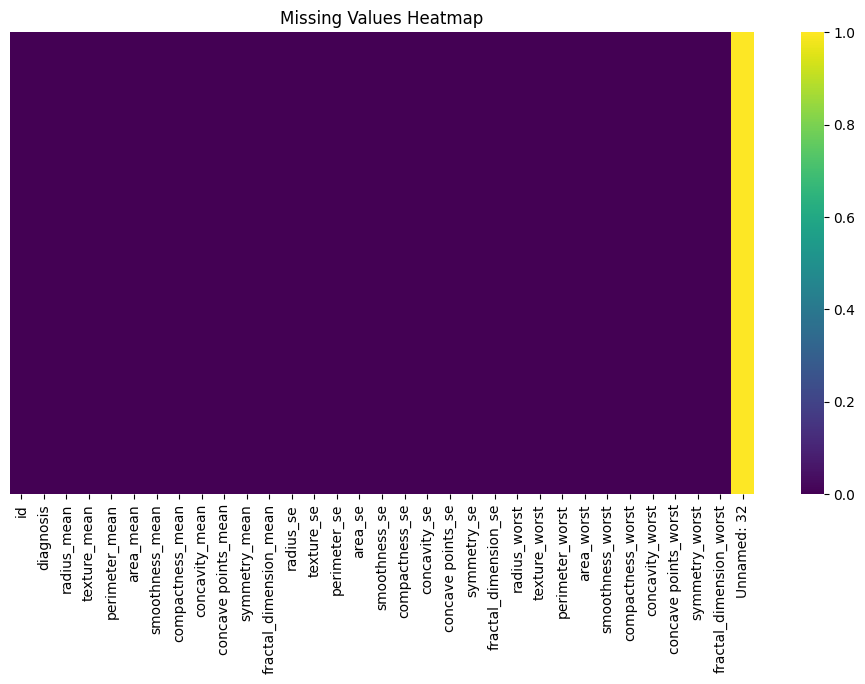

In [ ]:
print("Missing values")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])


plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
print("Basic statistics")
print(df.describe())

# For the diagnosis column specifically
print("\n Diagnosis distribution")
print(df['diagnosis'].value_counts())
print(f"Malignant Percentage: {(df['diagnosis'] == 'M').mean()*100:.2f}%")

Basic statistics
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064      

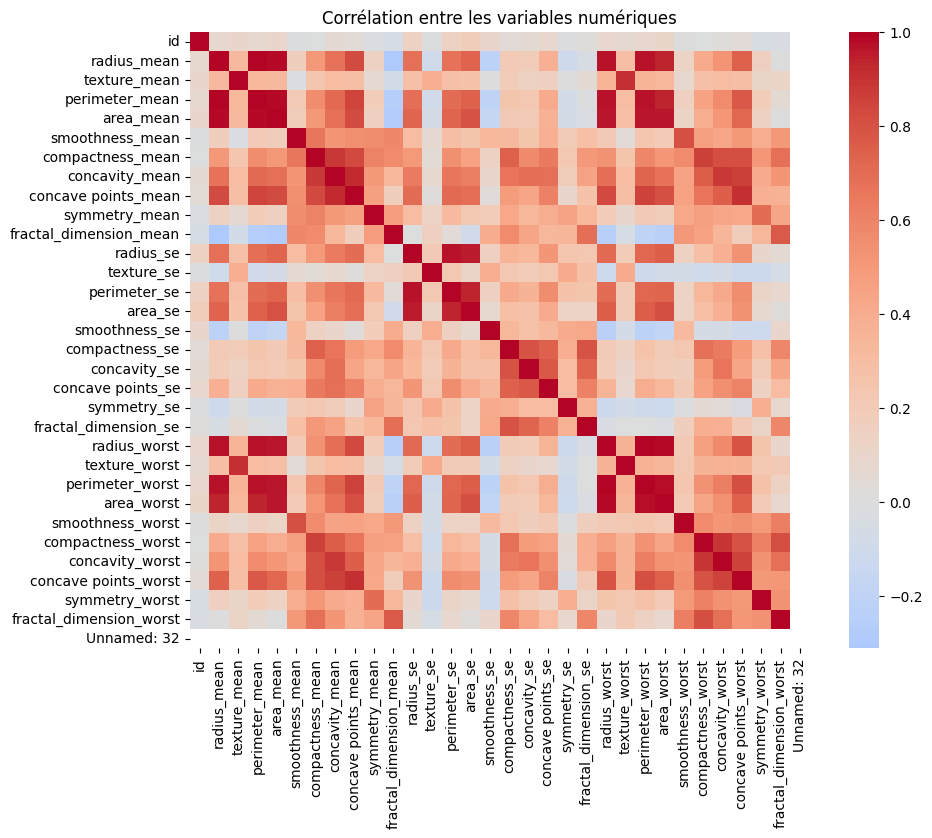

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Corrélation entre les variables numériques")
plt.show()

Outlier detection
Outliers in key features:
id: 81 outliers
radius_mean: 14 outliers
texture_mean: 7 outliers
perimeter_mean: 13 outliers
area_mean: 25 outliers


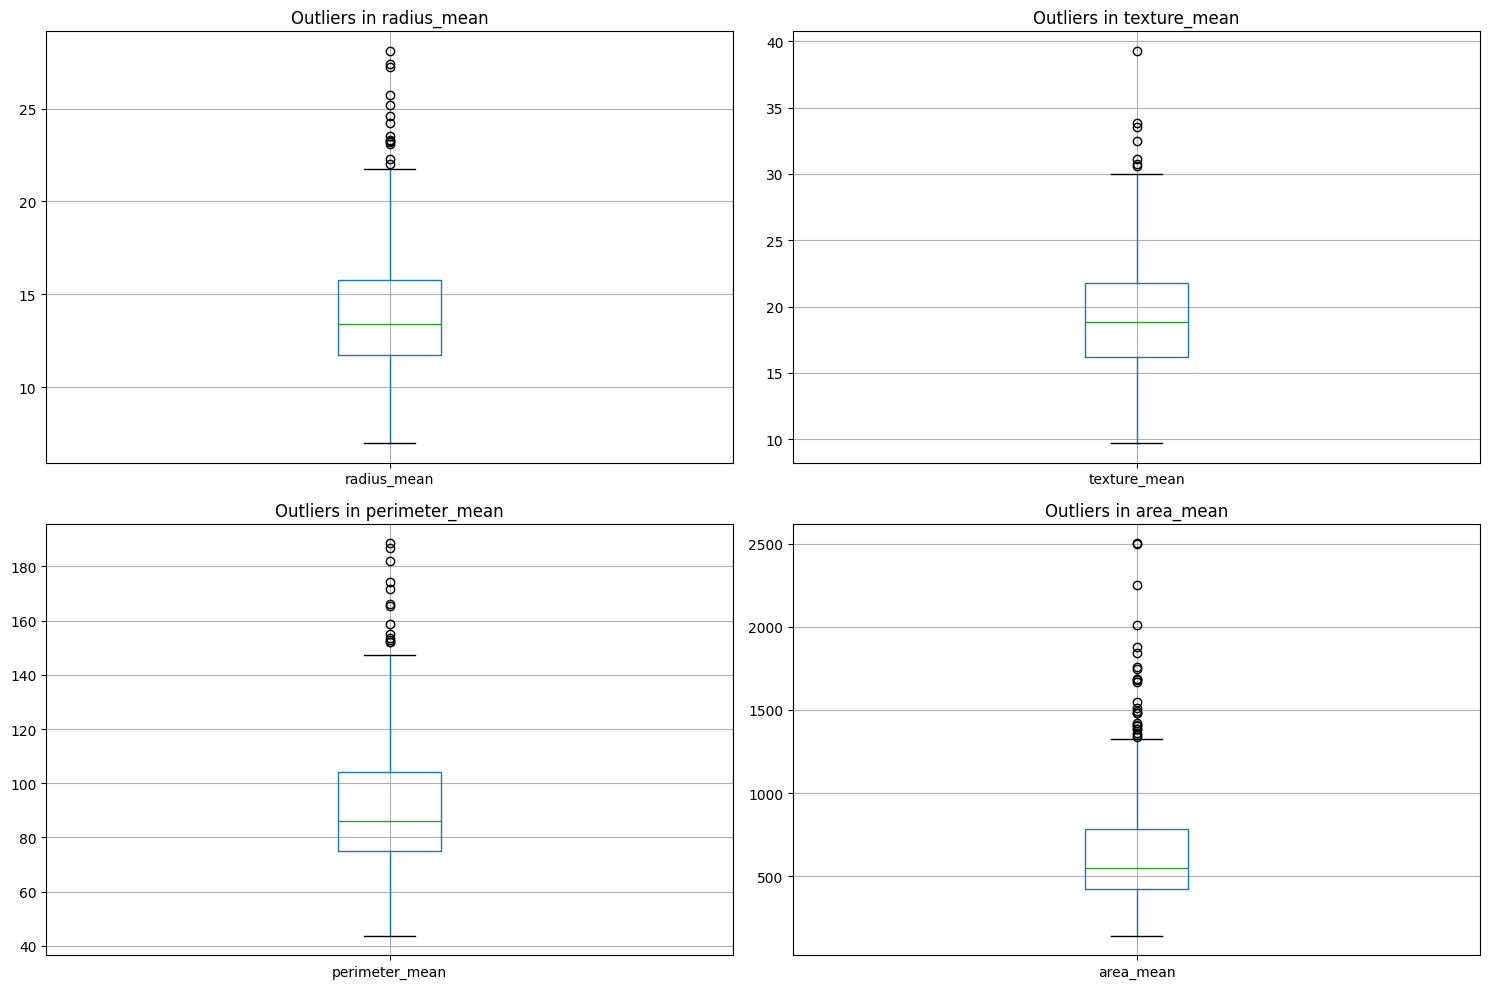

In [ ]:
print("Outlier detection")

# Method 1: IQR for numerical columns
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check outliers in key numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

print("Outliers in key features:")
for col in numerical_cols[:5]:  # Check first 5 numerical columns
    outliers = detect_outliers_iqr(df[col])
    print(f"{col}: {len(outliers)} outliers")

# Visualize outliers for key features
key_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f'Outliers in {feature}')

plt.tight_layout()
plt.show()

In [ ]:
print("Data quality summary")
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for constant columns (columns with only one value)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Constant columns: {constant_cols}")

# Check for columns with too many zeros
print("\n columns with many zeros")
for col in numerical_cols:
    zero_percent = (df[col] == 0).mean() * 100
    if zero_percent > 50:  # Show columns with more than 50% zeros
        print(f"{col}: {zero_percent:.2f}% zeros")

Data quality summary
Total records: 569
Total features: 33
Duplicate rows: 0
Constant columns: []

 columns with many zeros


Target variable analysis


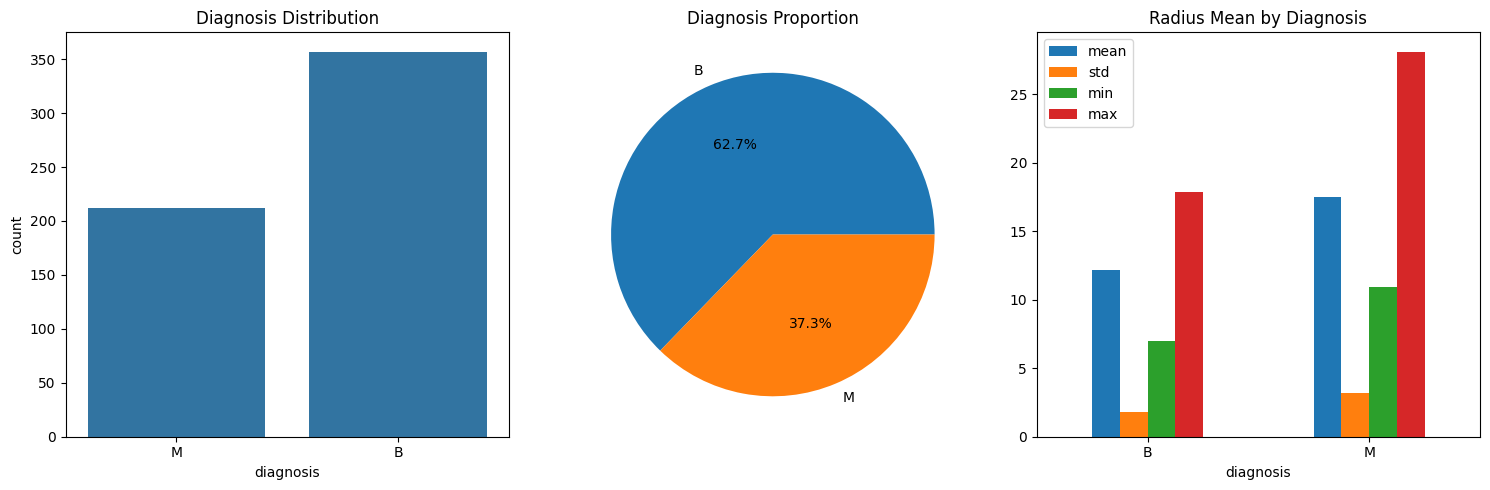

Diagnosis value counts:
diagnosis
B    357
M    212
Name: count, dtype: int64


In [ ]:
print("Target variable analysis")
diagnosis_counts = df['diagnosis'].value_counts()

plt.figure(figsize=(15, 5))

# Subplot 1: Count plot
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='diagnosis')
plt.title('Diagnosis Distribution')

# Subplot 2: Pie chart
plt.subplot(1, 3, 2)
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%')
plt.title('Diagnosis Proportion')

# Subplot 3: Statistics by diagnosis
plt.subplot(1, 3, 3)
diagnosis_stats = df.groupby('diagnosis')['radius_mean'].agg(['mean', 'std', 'min', 'max'])
diagnosis_stats.plot(kind='bar', ax=plt.gca())
plt.title('Radius Mean by Diagnosis')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"Diagnosis value counts:\n{diagnosis_counts}")

Correlation analysis
Top 10 features correlated with diagnosis:
diagnosis_numeric       1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
Name: diagnosis_numeric, dtype: float64

 Bottom 10 features correlated with diagnosis:
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
id                         0.039769
symmetry_se               -0.006522
texture_se                -0.008303
fractal_dimension_mean    -0.012838
smoothness_se             -0.067016
Unnamed: 32                     NaN
Name: diagnosis_numeric, dtype: float64


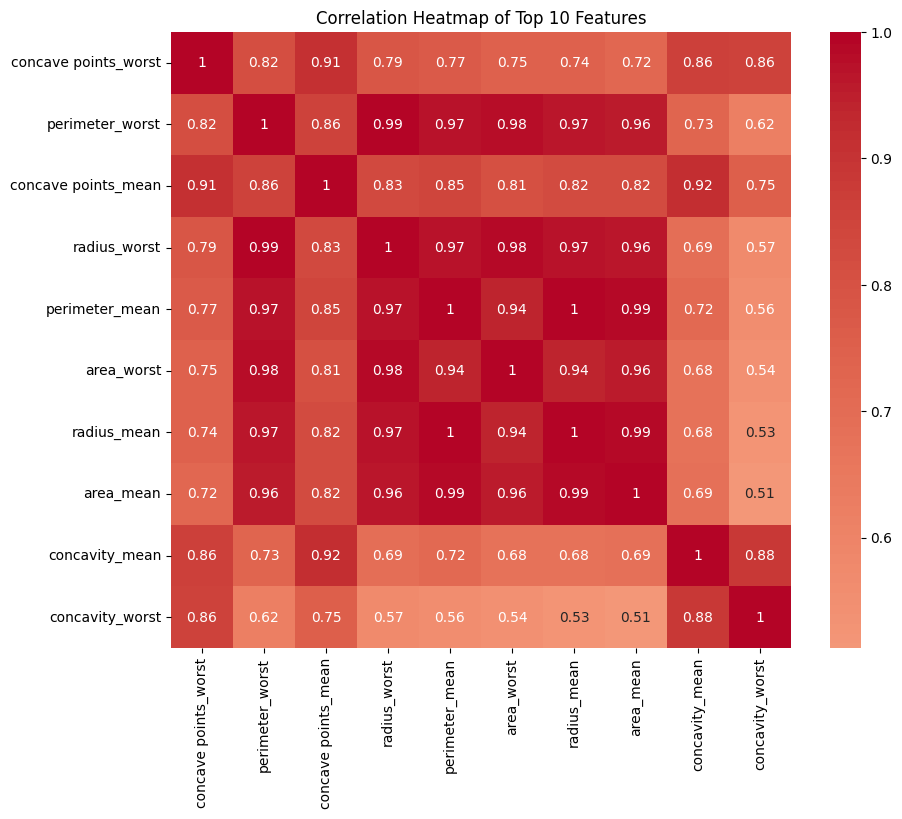

In [ ]:
print("Correlation analysis")

# Convert diagnosis to numerical for correlation
df_corr = df.copy()
df_corr['diagnosis_numeric'] = df_corr['diagnosis'].map({'M': 1, 'B': 0})

# Correlation with target
corr_with_target = df_corr.corr(numeric_only=True)['diagnosis_numeric'].sort_values(ascending=False)
print("Top 10 features correlated with diagnosis:")
print(corr_with_target.head(10))

print("\n Bottom 10 features correlated with diagnosis:")
print(corr_with_target.tail(10))

# Plot correlation heatmap for top features
top_corr_features = corr_with_target.index[1:11]  # Exclude diagnosis itself
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[top_corr_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

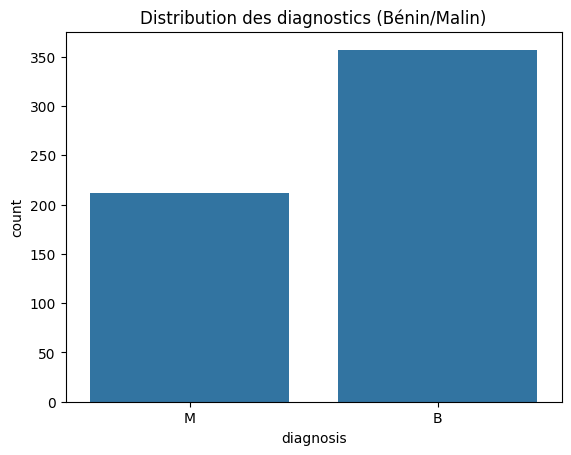

In [ ]:
sns.countplot(x="diagnosis", data=df)
plt.title("Distribution des diagnostics (Bénin/Malin)")
plt.show()

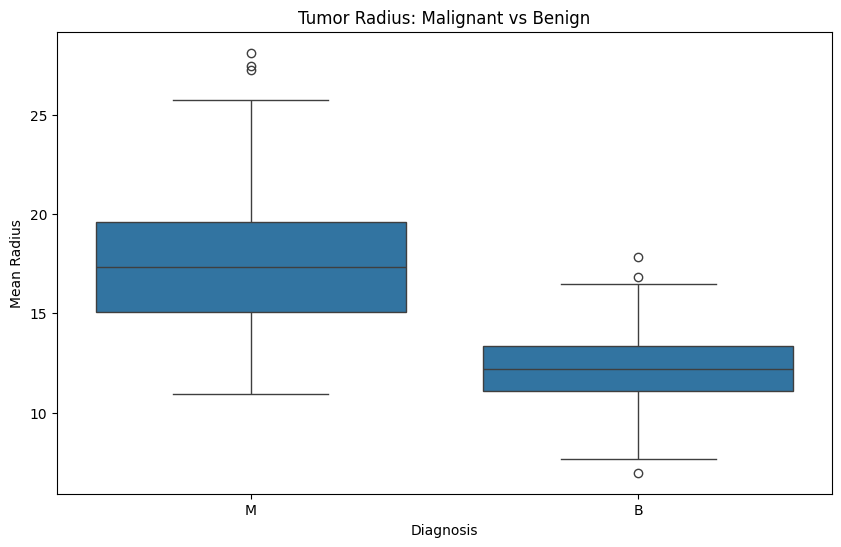

In [ ]:
# Compare a key feature between malignant and benign
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='diagnosis', y='radius_mean')
plt.title('Tumor Radius: Malignant vs Benign')
plt.ylabel('Mean Radius')
plt.xlabel('Diagnosis')
plt.show()

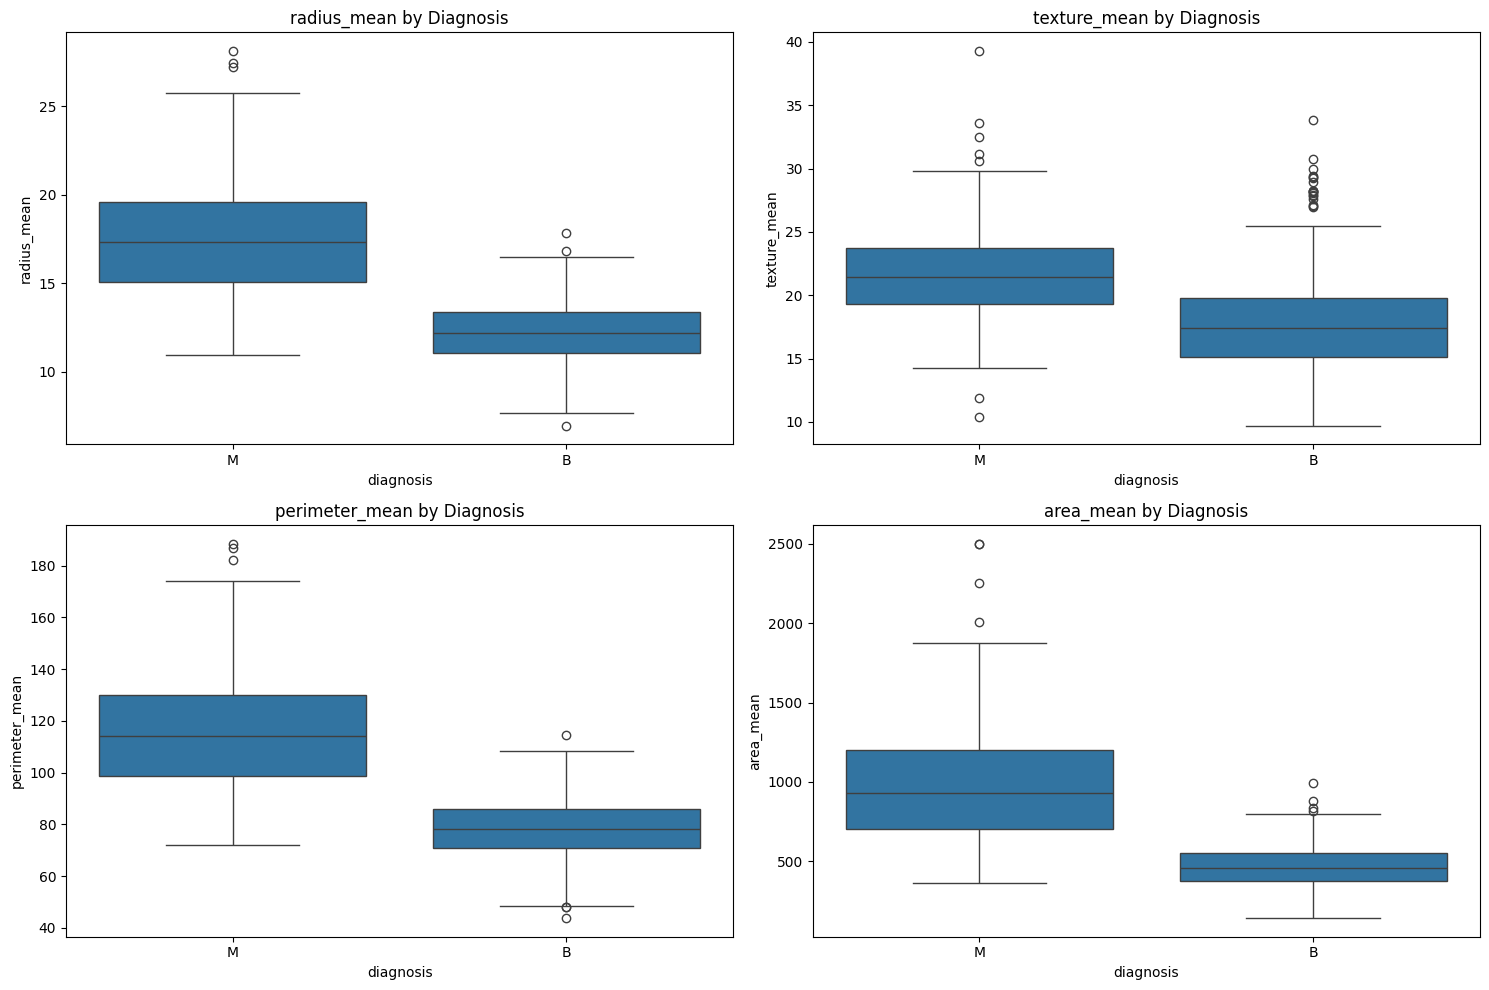

In [ ]:
# Selecting few key features to compare
features_to_plot = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df, x='diagnosis', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Diagnosis')

plt.tight_layout()
plt.show()

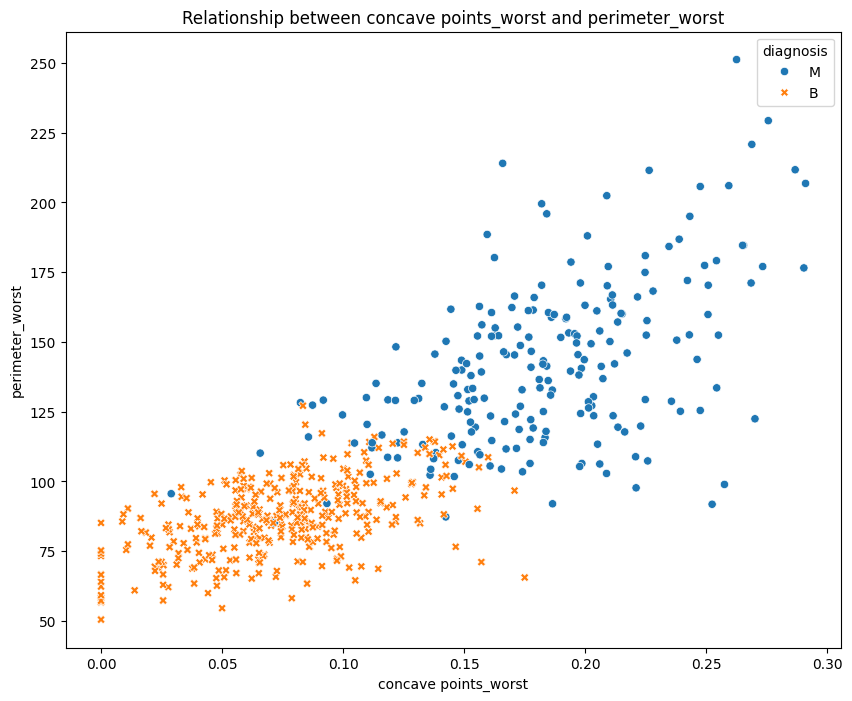

In [ ]:
# Find two features most correlated with diagnosis
top_two = corr_with_target.index[1:3]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x=top_two[0], y=top_two[1], hue='diagnosis', style='diagnosis')
plt.title(f'Relationship between {top_two[0]} and {top_two[1]}')
plt.show()

#III. Data Preparation

In [3]:
df.drop(columns=['Unnamed: 32', 'id'], inplace=True, errors='ignore')
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [4]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
scaler = StandardScaler()
X = df.drop('diagnosis', axis=1)
y = df["diagnosis"]
X_scaled = scaler.fit_transform(X)
scores = X_scaled

In [6]:
pca = PCA()
pca.fit(X_scaled)

PCA()

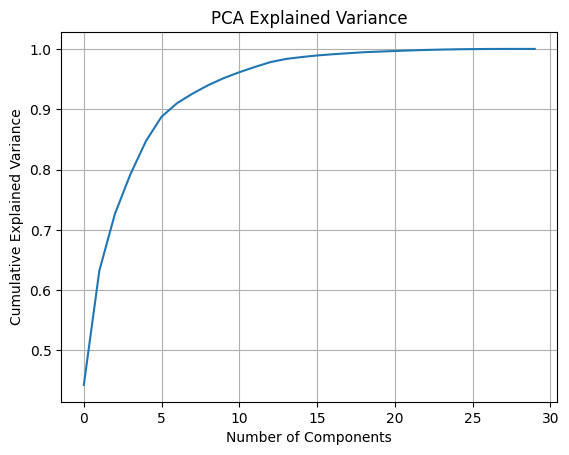

In [7]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

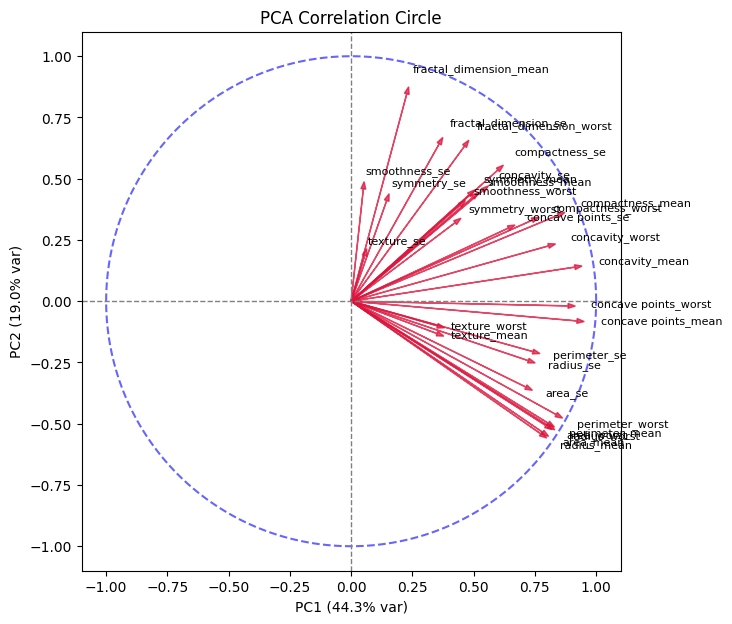

In [8]:
eigvals = pca.explained_variance_
loadings_corr = pca.components_.T * np.sqrt(eigvals)  # shape (n_features, 2)

fig, ax = plt.subplots(figsize=(7, 7))
theta = np.linspace(0, 2*np.pi, 500)
ax.plot(np.cos(theta), np.sin(theta), 'b--', alpha=0.6)

names = X.columns
for i, name in enumerate(names):
    x, y_ = loadings_corr[i, 0], loadings_corr[i, 1]
    ax.arrow(0, 0, x, y_, color='crimson', alpha=0.75,
             head_width=0.02, length_includes_head=True)
    ax.text(x*1.07, y_*1.07, name, fontsize=8)

ax.axhline(0, color='grey', lw=1, ls='--')
ax.axvline(0, color='grey', lw=1, ls='--')
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.set_title("PCA Correlation Circle")
ax.set_aspect('equal', 'box')
plt.show()

In [9]:
pcs = [f"PC{i}" for i in range(1, scores.shape[1] + 1)]
scores_df = pd.DataFrame(scores @ pca.components_.T, columns=pcs)
scores_df["diagnosis"] = df["diagnosis"]

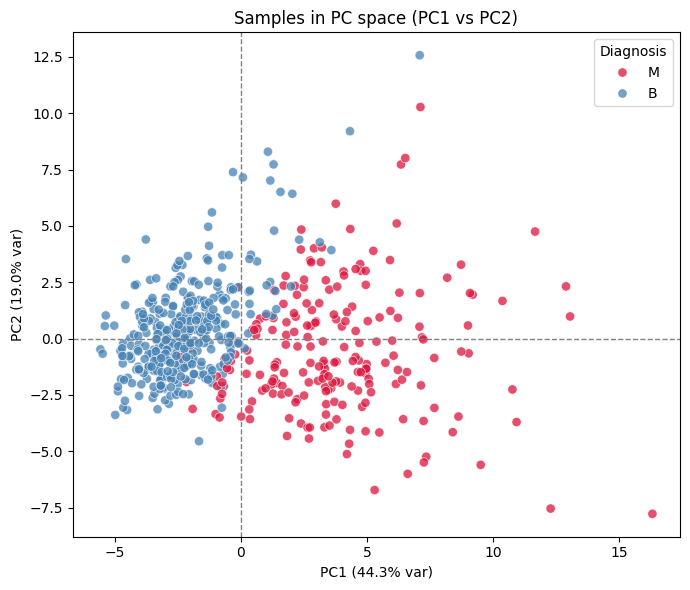

In [10]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=scores_df, x="PC1", y="PC2",
    hue="diagnosis",
    palette={"M": "crimson", "B": "steelblue"},
    alpha=0.75, edgecolor="white", s=45
)
plt.axhline(0, color="grey", ls="--", lw=1)
plt.axvline(0, color="grey", ls="--", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Samples in PC space (PC1 vs PC2)")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()

#IV. Modeling

## Random Forest Model

In this part, we build and evaluate a **Random Forest classifier** to predict whether a tumour is **benign (0)** or **malignant (1)** using the 30 numerical features of the dataset (data.csv)

#### 1. Data preparation for the model

- I start from the cleaned dataframe `df` (after removing `id` and `Unnamed: 32`).
- I create:
  - `X_model` = copy of all 30 feature columns  
  - `y_model` = copy of the `diagnosis` column
- I encode the target so that:
  - `B` → 0 (Benign)  
  - `M` → 1 (Malignant)
- The input features used by the model are the **standardised features** `X_scaled` (output of `StandardScaler`), so each variable has mean 0 and variance 1.
- I split the data into **70% training / 30% test** using `train_test_split` with `stratify=y_model` to keep the same proportion of benign and malignant cases in both sets.  
  This reproduces the protocol used in the research paper.

In [39]:
# Defensive copies (good practice)
X_model = X.copy()
y_model = y.copy()

In [12]:
# Encode target: Malignant = 1, Benign = 0
y_model = y_model.map({'M': 1, 'B': 0})

In [13]:
# 70% train / 30% test, stratified by the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_model, test_size=0.3, random_state=42, stratify=y_model
)

#### 2. Training the Random Forest

- I create a `RandomForestClassifier` with:
  - `n_estimators = 100` trees,
  - `class_weight = 'balanced'` to compensate the slight class imbalance,
  - `random_state = 42` for reproducibility.
- I fit the model **only on the training set** (`X_train`, `y_train`).

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# Fit on training data only
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### 3. Evaluation on the test set

- I predict the labels on `X_test` and print:
  - the **classification report** (precision, recall, f1-score for Benign and Malignant),
  - the **confusion matrix** (number of correct and incorrect predictions).
- I also compute the **test accuracy**, which is 0.9766 in my run.
- To check that the result is not due to a lucky split, I run a **5-fold cross-validation** on all the data (`X_scaled`, `y_model`).  
  The mean cross-validation accuracy is very close to the test accuracy, which suggests that the model generalises well and is not strongly overfitting.


In [15]:
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

=== Confusion Matrix ===
[[107   0]
 [  4  60]]


In [16]:
# 3. Evaluation on the test set
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9766


In [17]:
cv_mean = cross_val_score(rf, X_scaled, y_model, cv=5).mean()
print(f"Mean Cross-Validation Accuracy (5-fold): {cv_mean:.4f}")

Mean Cross-Validation Accuracy (5-fold): 0.9614


#### 4. Visualisation of one tree

- The Random Forest is an ensemble of 100 trees, which is hard to visualise directly.
- For interpretability, I plot **one tree** from the forest (`rf.estimators_[5]`) with a maximum depth of 3.
- This shows how the model uses the most important features (for example `area_worst`, `concave points_mean`, etc.) to split between benign and malignant tumours.

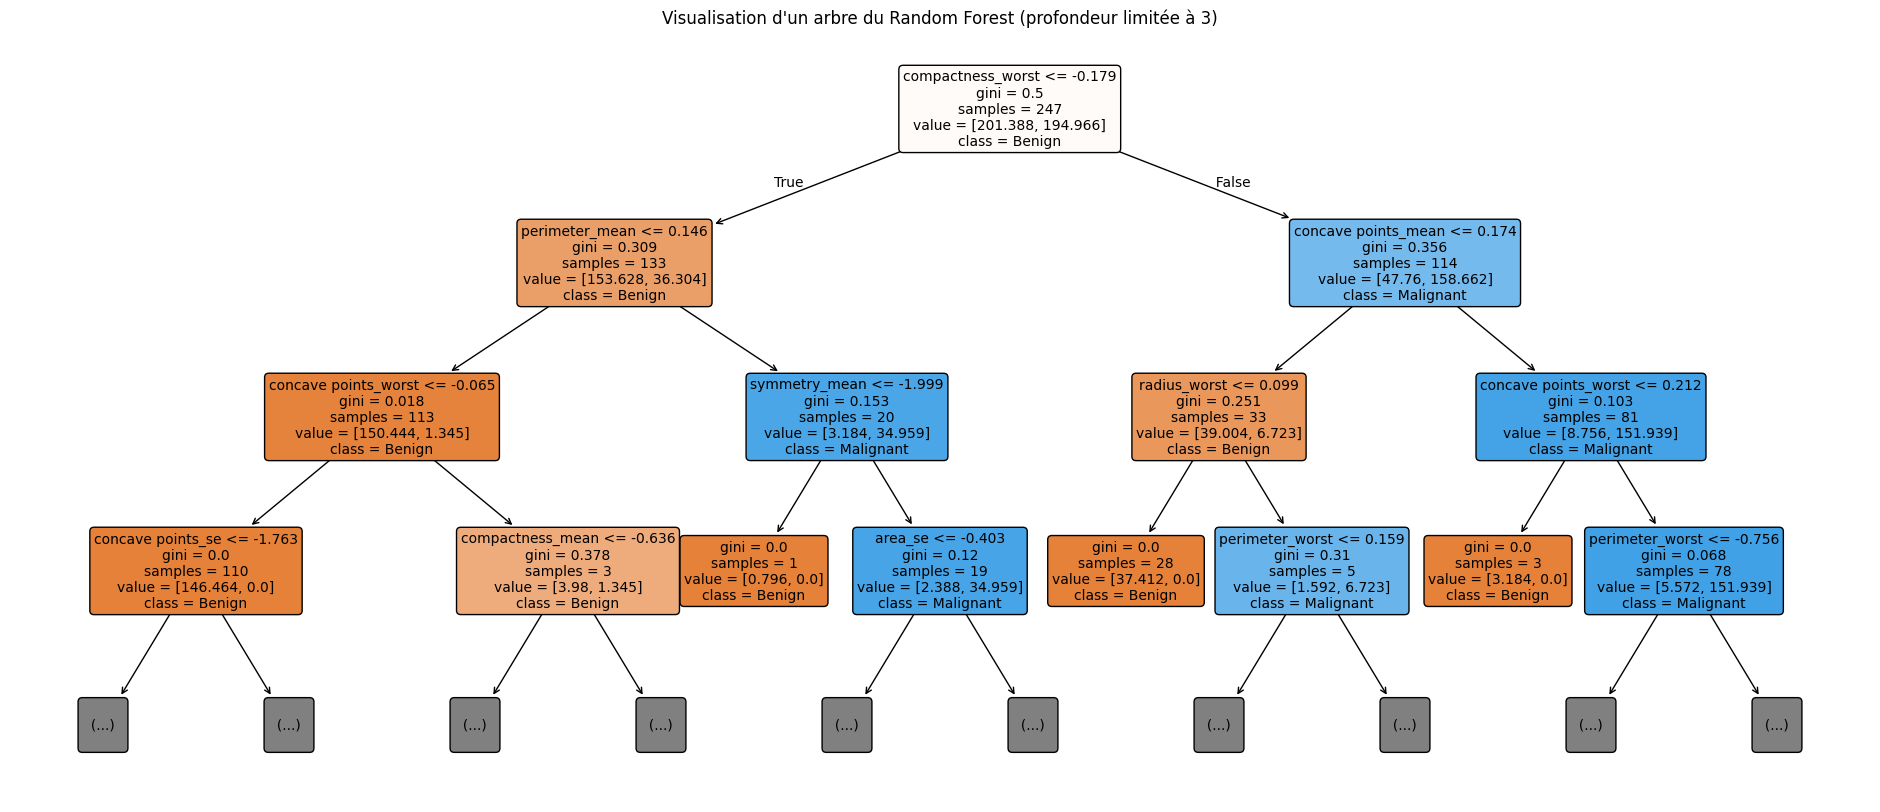

In [18]:
from sklearn.tree import plot_tree
features = X.columns
estimator = rf.estimators_[5]
plt.figure(figsize=(24, 10))
plot_tree(
    estimator,
    feature_names=features,
    class_names=["Benign", "Malignant"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title("Visualisation d'un arbre du Random Forest (profondeur limitée à 3)")
plt.show()

#### 5. ROC curve and AUC


- I use `predict_proba` to get the predicted probability of the malignant class on the test set.

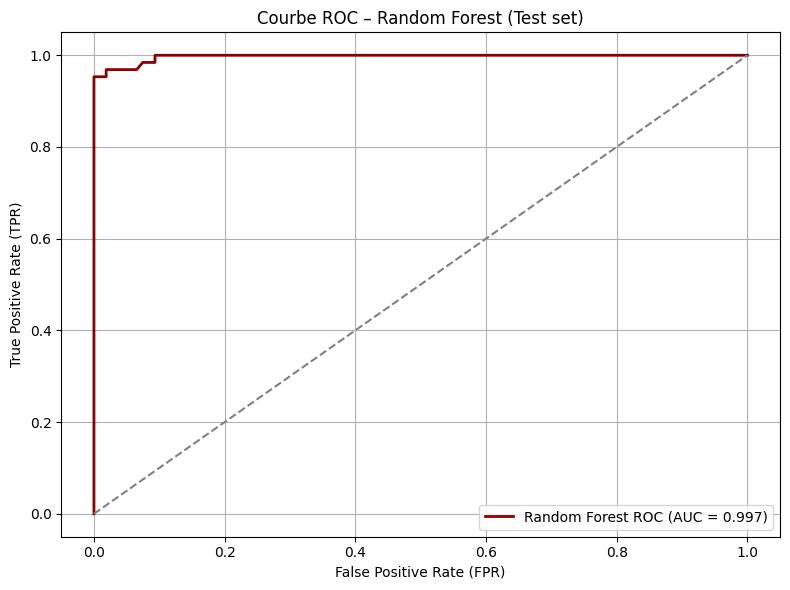

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilités pour la classe 1 (Malignant)
y_test_proba = rf.predict_proba(X_test)[:, 1]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_rf = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest ROC (AUC = {auc_rf:.3f})", color="darkred", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Courbe ROC – Random Forest (Test set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve of the Random Forest on the test set is very close to the top-left
corner. The Area Under the Curve is **AUC = 0.997**, which indicates an excellent
ability to separate benign (0) from malignant (1) tumours.  
The model keeps a very high true positive rate (sensitivity) while maintaining a
very low false positive rate, which is desirable in a medical screening context.

## MLP

In this part, we build and tune a **Multi-Layer Perceptron (MLP) classifier** to predict whether a tumour is **benign (0)** or **malignant (1)** using the same 30 numerical features as for the Random Forest.


### 1. Data preparation for the MLP

- Start from the cleaned dataframe `df`.
- Create:
  - `X_model_2` = copy of the 30 feature columns  
  - `y_model_2` = copy of the `diagnosis` column
- Encode the target:
  - `B` → 0 (Benign)
  - `M` → 1 (Malignant)
- Use the standardised features `X_scaled` as input to the MLP.
- Split into **70% train / 30% test**, stratified by the target, to keep the same class proportions.

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [21]:
X_model_2 = X.copy()
y_model_2 = y.copy()
y_model_2 = y_model_2.map({'M': 1, 'B': 0})

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_model_2,
    test_size=0.3,
    random_state=42,
    stratify=y_model_2
)

#### 2. Base MLP architecture

- Define a base `MLPClassifier` with:
  - activation `relu`
  - optimiser `adam`
  - batch size 32
  - `max_iter = 500`
  - `early_stopping = True` with `validation_fraction = 0.2` and `n_iter_no_change = 20`  
    → adds an anti-overfitting safety: training stops when validation score stagnates.
- The exact hidden layer sizes and regularisation will be chosen by grid search.

In [23]:
mlp_base = MLPClassifier(
    activation='relu',
    solver='adam',
    batch_size=32,
    max_iter=500,
    early_stopping=True,      # on garde une sécurité anti-overfitting
    validation_fraction=0.2,
    n_iter_no_change=20,
    random_state=42
)

#### 3. Hyperparameter search with GridSearchCV

- Search space:
  - `hidden_layer_sizes`:
    - `(32,)`, `(64,)`  → one hidden layer
    - `(32, 16)`, `(64, 32)` → two hidden layers
  - `alpha` ∈ {1e-4, 1e-3, 1e-2} (L2 regularisation)
  - `learning_rate_init` ∈ {1e-3, 5e-4}
- Use `GridSearchCV` with:
  - estimator: `mlp_base`
  - scoring: `"accuracy"`
  - `cv = 5`
- Fit the grid on all data (`X_scaled`, `y_model_2`) and display:
  - best hyperparameters
  - best mean CV accuracy.

In [24]:
param_grid = {
    "hidden_layer_sizes": [
        (32,),         # une couche
        (64,),
        (32, 16),      # deux couches
        (64, 32)
    ],
    "alpha": [1e-4, 1e-3, 1e-2],          # régularisation L2
    "learning_rate_init": [1e-3, 5e-4]    # taux d’apprentissage
}

grid = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

In [25]:
grid.fit(X_scaled, y_model_2)

GridSearchCV(cv=5,
             estimator=MLPClassifier(batch_size=32, early_stopping=True,
                                     max_iter=500, n_iter_no_change=20,
                                     random_state=42, validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(32,), (64,), (32, 16),
                                                (64, 32)],
                         'learning_rate_init': [0.001, 0.0005]},
             scoring='accuracy')

In [26]:
print("=== Meilleurs hyperparamètres trouvés ===")
print(grid.best_params_)
print(f"Meilleure accuracy moyenne CV (5-fold): {grid.best_score_:.4f}")

=== Meilleurs hyperparamètres trouvés ===
{'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}
Meilleure accuracy moyenne CV (5-fold): 0.9772


#### 4. Evaluation on the test set

- Take the best estimator returned by `GridSearchCV` and refit it on the **training set**.
- On the test set:
  - print the **classification report** (precision, recall, f1-score),
  - print the **confusion matrix**,
  - compute the **test accuracy**.
- Also compute the **training accuracy** to check overfitting.
- In my run:
  - Test accuracy ≈ 0.977
  - Train accuracy ≈ 0.993  
  The values are close, which indicates good generalisation and limited overfitting.

In [27]:
best_mlp = grid.best_estimator_
best_mlp.fit(X_train, y_train)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(64, 32),
              max_iter=500, n_iter_no_change=20, random_state=42,
              validation_fraction=0.2)

In [28]:
y_pred = best_mlp.predict(X_test)
print("\n=== Best MLP - Classification Report (Test) ===")
print(classification_report(y_test, y_pred))

print("=== Best MLP - Confusion Matrix (Test) ===")
print(confusion_matrix(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print(f"Best MLP Test Accuracy: {test_acc:.4f}")

# Train accuracy pour vérifier l’overfitting
y_train_pred = best_mlp.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Best MLP Train Accuracy: {train_acc:.4f}")


=== Best MLP - Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

=== Best MLP - Confusion Matrix (Test) ===
[[107   0]
 [  4  60]]
Best MLP Test Accuracy: 0.9766
Best MLP Train Accuracy: 0.9925


#### 5. ROC curve and AUC

- Use `predict_proba` to get the probability of the malignant class on the test set.
- Compute and plot the **ROC curve** and the **AUC** for the tuned MLP.

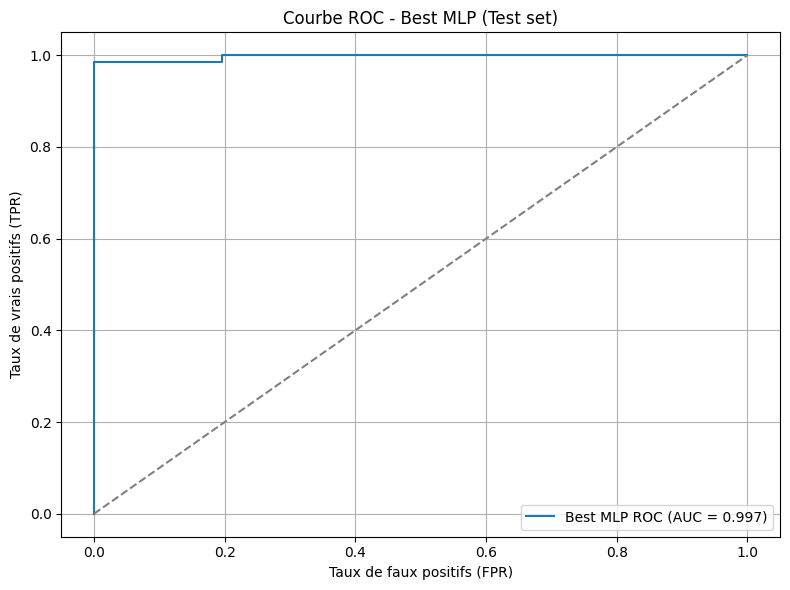

In [29]:
y_test_proba = best_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc_mlp = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Best MLP ROC (AUC = {auc_mlp:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - Best MLP (Test set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve of the tuned MLP on the test set is very close to the top-left
corner, with an AUC of about **0.997**. This shows an excellent ability to
separate benign from malignant tumours. Together with a test accuracy around
97.7% and a train accuracy slightly higher, the model appears powerful and only
mildly overfitted.

## GRU-SVM

We implement a **GRU-SVM model**: a GRU network that outputs a single linear score,
trained with **hinge loss** (SVM style) instead of cross-entropy.

### 1. Data preparation

- The starting point is still `X_scaled` (30 standardised features) and `y`.
- For the SVM formulation we encode the labels as:
  - `M` → +1
  - `B` → −1
- GRUs expect a 3D input `(samples, timesteps, features)`.  
  Here we treat the 30 features as a “sequence” of length 30 with 1 feature per step:
  `X_gru.shape = (n_samples, 30, 1)`.
- We perform a **70% / 30%** train–test split, stratified on `y_gru`.

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropou
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [31]:
y_gru = y.map({'M': 1, 'B': -1}).astype('float32')

In [32]:
n_samples, n_features = X_scaled.shape
X_gru = X_scaled.reshape(n_samples, n_features, 1)

In [33]:
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(
    X_gru,
    y_gru,
    test_size=0.3,
    random_state=42,
    stratify=y_gru
)

### 2. GRU-SVM architecture

- Custom metric `svm_accuracy`:
  - takes the **sign** of the model output,
  - compares it to the true labels in {−1, +1}.
- Model structure:
  - one `GRU(32)` layer (sequence → 32-dim embedding),
  - one `Dropout(0.3)` layer to reduce overfitting,
  - one `Dense(1, activation='linear')` output → raw SVM score.
- We compile with:
  - optimiser: `Adam(learning_rate=1e-3)`
  - loss: `'hinge'` (SVM margin loss)
  - metric: `svm_accuracy`.

In [34]:
def svm_accuracy(y_true, y_pred):
    # signe de la prédiction
    y_pred_sign = tf.sign(y_pred)
    # si le modèle sort exactement 0, on force à +1
    y_pred_sign = tf.where(tf.equal(y_pred_sign, 0.0),
                           tf.ones_like(y_pred_sign),
                           y_pred_sign)
    equal = tf.equal(y_true, y_pred_sign)
    return tf.reduce_mean(tf.cast(equal, tf.float32))

gru_svm = Sequential([
    GRU(32, input_shape=(n_features, 1), return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')    # sortie linéaire pour hinge
])

gru_svm.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='hinge',
    metrics=[svm_accuracy]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3. Training the GRU-SVM

- Use `EarlyStopping` on `val_loss` with:
  - `patience = 30`
  - `restore_best_weights = True`
- Training configuration:
  - validation split: 20% of the training set,
  - `epochs = 300` (training may stop earlier thanks to early stopping),
  - `batch_size = 32`,
  - `verbose = 0` for a clean notebook.
- At the end, we print the epoch where training actually stopped.

In [35]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history_gru = gru_svm.fit(
    X_train_gru, y_train_gru,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print(f"Training stopped at epoch {len(history_gru.history['loss'])}")

Training stopped at epoch 75


### 4. Evaluation on the test and train sets

- The GRU-SVM outputs a real score in ℝ.  
  We convert it to labels in {−1, +1} using a **sign threshold at 0**:
  - score ≥ 0 → +1 (Malignant)
  - score  < 0 → −1 (Benign)
- For compatibility with scikit-learn metrics, we also build 0/1 versions:
  - `1` = Malignant, `0` = Benign.
- On the **test set**, we print:
  - classification report,
  - confusion matrix,
  - test accuracy.
- On the **train set**, we compute:
  - training accuracy,
  - to check for overfitting (train vs test).

In [36]:
y_test_scores = gru_svm.predict(X_test_gru).flatten()
y_test_pred_svm = np.where(y_test_scores >= 0, 1.0, -1.0)

# pour les métriques scikit-learn classiques, on repasse en 0/1
y_test_bin = (y_test_gru == 1).astype(int)
y_pred_bin = (y_test_pred_svm == 1).astype(int)

print("\n=== GRU-SVM - Classification Report (Test) ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=['Benign', 'Malignant']))

print("=== GRU-SVM - Confusion Matrix (Test) ===")
print(confusion_matrix(y_test_bin, y_pred_bin))

test_acc = accuracy_score(y_test_bin, y_pred_bin)
print(f"GRU-SVM Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

=== GRU-SVM - Classification Report (Test) ===
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97       107
   Malignant       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

=== GRU-SVM - Confusion Matrix (Test) ===
[[106   1]
 [  6  58]]
GRU-SVM Test Accuracy: 0.9591


In [37]:
# --- Accuracy sur le TRAIN pour détecter l’overfitting ---
y_train_scores = gru_svm.predict(X_train_gru).flatten()
y_train_pred_svm = np.where(y_train_scores >= 0, 1.0, -1.0)

y_train_bin = (y_train_gru == 1).astype(int)
y_train_pred_bin = (y_train_pred_svm == 1).astype(int)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train_bin, y_train_pred_bin)
print(f"GRU-SVM Train Accuracy: {train_acc:.4f}")
print(f"GRU-SVM Test  Accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
GRU-SVM Train Accuracy: 0.9673
GRU-SVM Test  Accuracy: 0.9591


### 5. ROC curve and AUC

- The SVM score is a signed distance to the decision boundary.  
  We convert this score to a pseudo-probability using a logistic function:
  \[ p = 1 / (1 + e^{-score}) \]
- With these probabilities, we compute:
  - the **ROC curve**,
  - the **AUC** for the GRU-SVM on the test set.

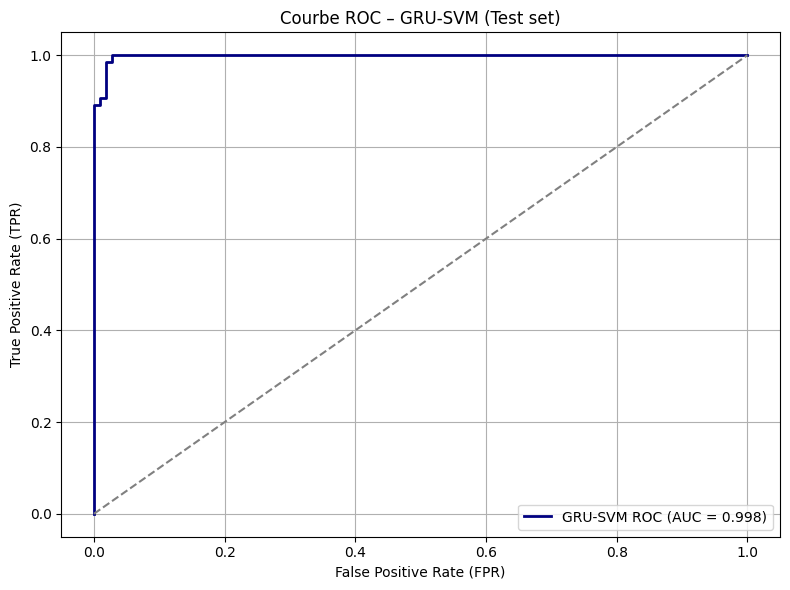

In [38]:
y_test_proba = 1 / (1 + np.exp(-y_test_scores))

fpr, tpr, _ = roc_curve(y_test_bin, y_test_proba)
auc_gru = roc_auc_score(y_test_bin, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"GRU-SVM ROC (AUC = {auc_gru:.3f})", color="navy", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Courbe ROC – GRU-SVM (Test set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve for GRU-SVM is close to the top-left corner with a high AUC
(≈ 0.99 in my run). Combined with similar train and test accuracies, this
indicates that the GRU-SVM model also achieves very good separation between
benign and malignant tumours, without strong overfitting.

#V. Evaluation

#VI. Deployment